In [23]:
%run ../talktools.py

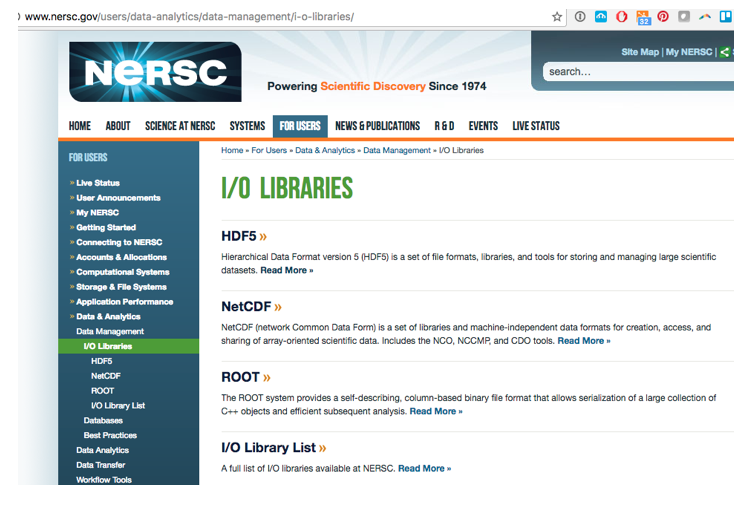

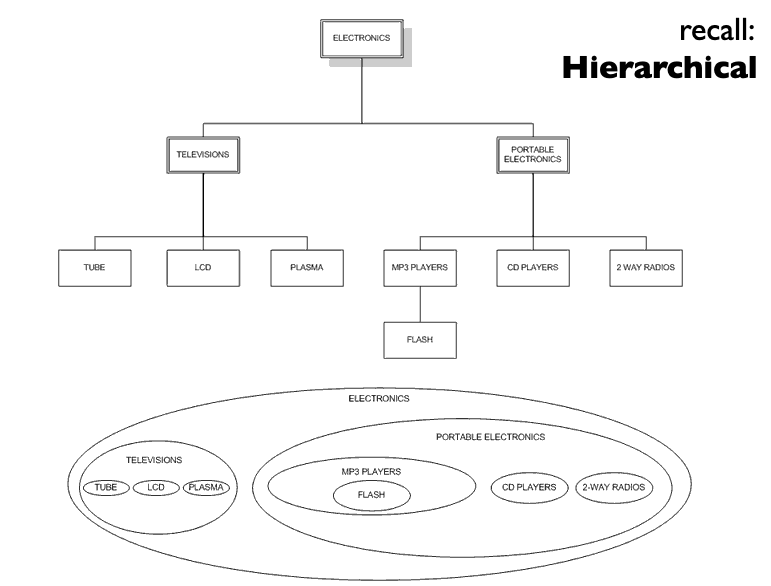

## HDF5

C-based API "database," developed for scientific applications by NCSA 

Views data like a file system (with paths /food/spam/ingredients). You connect to the data on disk (like in sqlite3)

Two types of objects in HDF5:

- Datasets: multidimensional homogeneous arrays. They can have attributes (metadata)
    - Table: like record-arrays in numpy
    - Array
- Groups - containers holding datasets and other groups (like "folders")

Several Nice Things about HDF5 itself:

- portability - document is self-describing and platform independent (endian issues are dealt with client-side)
- hugely scalable datamodel (2<sup>63</sup>-sized tables)
- Clients made to run massively parallel

Using PyTables and HDF5
-----------------------

pytables & h5py are Pythonic APIs for HDF5

- happy to use numpy arrays 
- works on compressed datafiles
- open-sourced

"PyTables presents a database-like approach to data storage, providing features like indexing and fast “in-kernel” queries on dataset contents. It also has a custom system to represent data types." -- http://docs.h5py.org/en/latest/faq.html#what-s-the-difference-between-h5py-and-pytables

First we'll open a new HDF5 for writing (note: the "w" implies we will overwrite the file we have on disk)

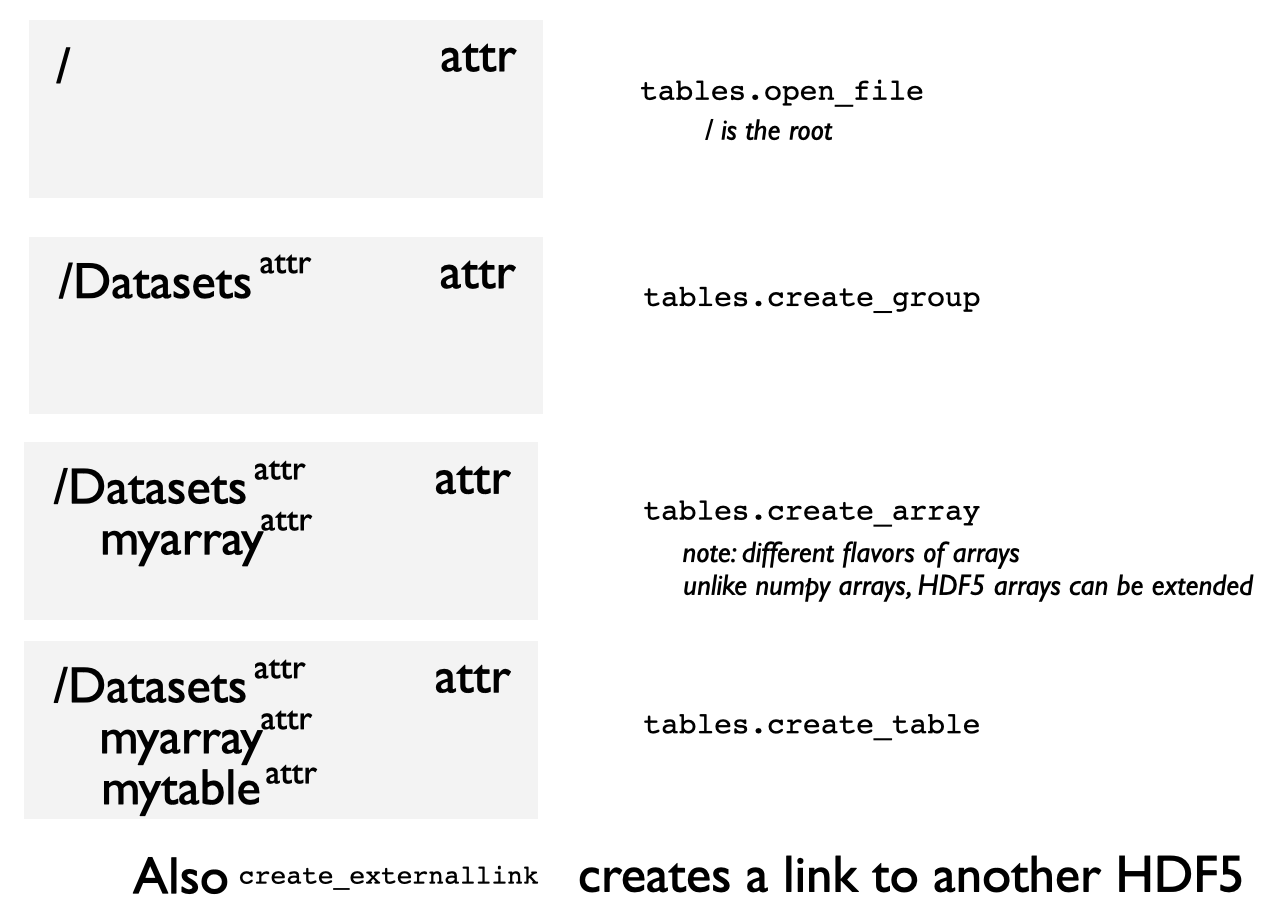

In [ ]:
!rm spam.h5

In [ ]:
import numpy as np
from tables import *
h5file = open_file("spam.h5",mode = "w", title = "PyTables/HDF5 test file")
h5file

Filters sets the protocols for the way all data will be treated in the file. `fletcher32 = True`, for instance will enforce checksums (slower, but more stable data), `complevel` is the compression level, etc.

Now, let's create a 100$\times$100 random image with `create_array` and associate it with a group called "Datasets"

In [ ]:
datasets = h5file.create_group(h5file.root, "Datasets", "Test data sets")
h5file.create_array(datasets, 'dataset1', np.random.random((100,100)), 
                    "Test data set #1")

Now let's create a complex object which we'll call a "Particle" that has the properties like name, atomic number, mass, etc.

In [ ]:
class Particle(IsDescription):
    name        = StringCol(16, pos=1) # 16-character String
    atomic_num  = IntCol(pos=2)        # integer
    mass        = FloatCol(pos=3)      # double (double-precision)
    pressure    = Float32Col(shape=(2,3))

table1 = h5file.create_table(datasets, "particles", Particle)

In [ ]:
row = table1.row
row

Let's add some data into the first particle

In [ ]:
row["name"] = "oxygen"
row["atomic_num"] = 8
row["mass"] = 15.9994
row["pressure"] = [[1,2,3],[-1,1,3]]
row.append() ; table1.flush()
h5file.root.Datasets.particles[0]

Notice that, unlike numpy arrays, we can append new data. So this seems more like a DB in this respect.

In [ ]:
row = table1.row
row["name"] = "bezerkilum"
row["atomic_num"] = 150
row["mass"] = 360.0
row["pressure"] = [[1,2,3],[1,0,3]]
row.append() ; table1.flush()
h5file.root.Datasets.particles[1]

In [ ]:
[row['name'].decode() for \
                      row in table1.where('(atomic_num > 5) & (mass < 100.0)')]

In [ ]:
for row in table1:
    print(row["name"].decode())

In [ ]:
h5file.close()

# h5py

Groups work like dictionaries, and datasets work like NumPy arrays

http://docs.h5py.org/en/latest/quick.html


In [ ]:
import h5py
import numpy as np
!rm spam-h5py.h5
h5file = h5py.File("spam-h5py.h5",mode = "w")
h5file

In h5py, "Datasets are very similar to NumPy arrays. They are homogenous collections of data elements, with an immutable datatype and (hyper)rectangular shape. Unlike NumPy arrays, they support a variety of transparent storage features such as compression, error-detection, and chunked  I/O." -- http://docs.h5py.org/en/latest/high/dataset.html

In [ ]:
datasets = h5file.create_group("Datasets")

In [ ]:
datasets.create_dataset('Datasets/dataset1', data=np.random.random((100,100)))
datasets.create_dataset('Datasets/dataset2', data=np.random.random((100,100)),
                        compression="gzip", compression_opts=9)

In [ ]:
data = datasets.get('Datasets/dataset2')

In [ ]:
data.nbytes

In [ ]:
data[2:10,1:9:3]

In [ ]:
dtype = [("name","S16"),("atomic_num","i4")] 

In [ ]:
datasets.create_dataset("Particle", shape=(100,1), dtype=dtype)

In [ ]:
pdata = datasets.get("Particle")

In [ ]:
pdata[0] = ("oxygen", 8)

In [ ]:
h5file.close()

In [ ]:
with h5py.File("spam-h5py.h5",mode = "r") as f:
    pdata = f.get("Datasets/Particle")
    print(pdata[0])

In [ ]:
%matplotlib inline

In [ ]:
# jupyterlab
from jupyterlab_h5web import H5Web
H5Web("spam-h5py.h5")

## Pandas interaction with hdf5

“Python and HDF5 - Fast Storage for Large Data”

See https://pandas.pydata.org/pandas-docs/stable/io.html#io-hdf5

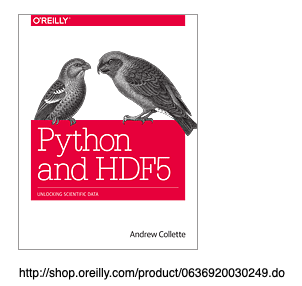